# BLU05  - Exercise Notebook 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import hashlib # for grading purposes

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

# Functions

In [2]:
def load_emissions_data():
    emissions = pd.read_csv('data/emissions.csv')
    emissions = emissions[emissions.Description=='Coal Electric Power Sector CO2 Emissions']
    emissions['YYYYMM'] = emissions['YYYYMM'].astype(str)
    emissions['YYYYMM'] = pd.to_datetime(emissions['YYYYMM'],format='%Y%m', errors='coerce').dropna()
    emissions = emissions.set_index('YYYYMM')
    emissions = emissions.sort_index()
    emissions['Value'] = emissions.Value.astype(float)
    emissions.index = emissions.index.rename('date')
    emissions = emissions['Value']
    emissions = emissions['1980':'2000']
    emissions = emissions.resample('MS').mean()
    return emissions

In [3]:
def load_coal_data():
    np.random.seed(10)
    df = pd.read_csv('data/MER_T06_01.csv')
    df = df[df.Description=='Coal Consumption']
    df.YYYYMM = pd.to_datetime(df.YYYYMM, format='%Y%m',errors='coerce' )
    df = df.set_index('YYYYMM')
    df = df.loc['1980':'2000']
    df.Value = pd.to_numeric(df.Value)
    df.Value = df.Value + np.random.normal(0,df.Value.mean()/20,len(df.Value))
    return df.Value.to_frame()

# Let's predict CO2 emissions!

In [4]:
emissions = load_emissions_data()

In [5]:
emissions_train = emissions[:'1998']
emissions_test = emissions['1998':]

##### Plot the series to get an idea of what's going on

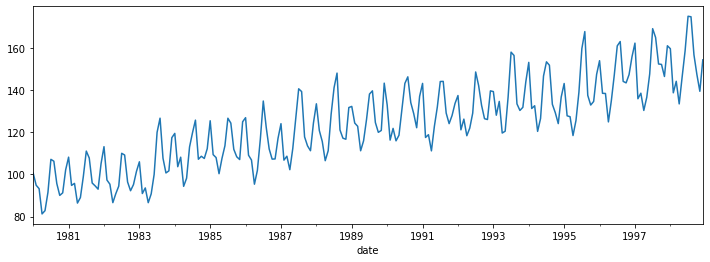

In [6]:
emissions_train.plot();

Get a feel for the data:
 - Is the magnitude of the variance changing? 
 - Is there seasonality? 
 - Does it have an apparent trend? 

### Q1: Make the time series stationary

In [7]:
# emissions_train_log = 
# emissions_train_log_detrend = 
# emissions_train_log_detrend_without_nans =  

emissions_train_log = np.log(emissions_train)
emissions_train_log_detrend = emissions_train_log.diff()
emissions_train_log_detrend_without_nans = emissions_train_log_detrend.dropna()

emissions_train_log_detrend_without_nans.head()

date
1980-02-01   -0.058411
1980-03-01   -0.017568
1980-04-01   -0.137386
1980-05-01    0.018778
1980-06-01    0.099917
Freq: MS, Name: Value, dtype: float64

In [8]:
expected_hash = 'a9bd2829b2d2191c657f4e3b13bf0feca647eb3630a15ebac45aa578d6199e3d'
assert hashlib.sha256(str(np.round(emissions_train_log_detrend_without_nans[0],5)).encode()).hexdigest() == expected_hash

### Q2: Use autocorrelations to look for seasonality.

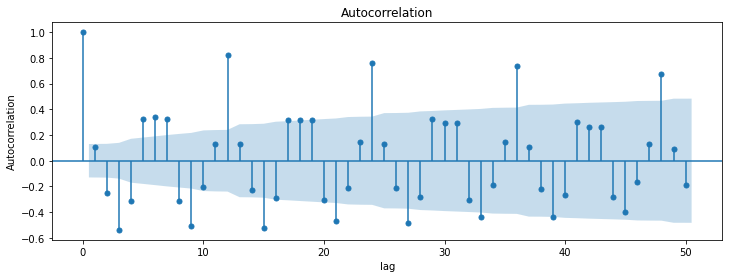

In [9]:
# Use the autocorrelations plots to infer what is the seasonality of the time series.

#plot_acf(what goes here?)  
#plt.xlabel('lag')
#plt.ylabel('Autocorrelation')
#plt.show()

# S = 

plot_acf(emissions_train_log_detrend_without_nans, alpha=.05, lags=50) #alpha - confidence interval
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

S = 12

In [10]:
assert isinstance(S, int)
expected_hash = '6b51d431df5d7f141cbececcf79edf3dd861c3b4069f0b11661a3eefacbba918'
assert hashlib.sha256(str(S).encode()).hexdigest() == expected_hash

### Q3: Fit a SARIMAX model on the train set using AutoArima

In [11]:
sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=12, method='nm', maxiter=20)

In [12]:
# Use S according to what you saw on the previous question.
# Use the logged train dataset, but not the diffed since pmdarima can find that on his own.
# Use the 'nm' method and maxiter=20

# sarimax =
# sarimax.fit()

sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=12, method='nm', maxiter=20)
sarimax.fit(emissions_train_log.dropna())

results = sarimax.fit(emissions_train_log.dropna())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-720.204, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-459.990, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-737.840, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-594.557, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-461.884, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-460.564, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-782.066, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-588.196, Time=0.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-787.849, Time=0.45 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-753.811, Time=0.43 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-732.110, Time=0.43 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-800.833, Time=0.43 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-793.954, Time=0.17 sec
 ARIMA(0,1,0)(2,0,0)[12]

In [13]:
expected_hash = 'ea646d4b57803d0a111b4566d42e889dcf5d96907d7dc50b6c98cc8a8fa63998'
assert hashlib.sha256(str(sarimax.get_params()).encode()).hexdigest() == expected_hash

### Q4: Use that model to do the in sample predictions and calculate the corresponding MAE

In [14]:
# Don't forget that you used the logged dataset when training the model.

predictions = np.exp(sarimax.predict_in_sample())
mae = mean_absolute_error(emissions_train,predictions)
mae

4.140678932373378

In [15]:
expected_hash = 'aa220c34fecec5633f7b7198a842f880bef8e0ec9166dcd370ac55886d2f012f'
assert hashlib.sha256(str(np.round(predictions,1)).encode()).hexdigest() == expected_hash

expected_hash = 'e979952da01e58fd4bfe9684a16ab22397e28f92ceed1c6bb16f93520a3e2134'
assert hashlib.sha256(str(np.round(mae,1)).encode()).hexdigest() == expected_hash

### Q5: Forecast the test set using a multi-step forecast and calculate the corresponding MAE

In [16]:
# Don't forget that you used the logged dataset when training the model.

# forecast = 
# mae = 

forecast = np.exp(sarimax.predict(36))
mae = mean_absolute_error(forecast, emissions_test)
mae

4.769905556883459

In [17]:
expected_hash = 'bb3c550c88ef9f8bc876af6f6064bd131834ce679c6d9bd67bbac978b24ba0b1'
assert hashlib.sha256(str(np.round(forecast,1)).encode()).hexdigest() == expected_hash

expected_hash = '9c7f38a9ac4f5de592be486948ac944aff688f914e3b74e6917c7fe4715a561e'
assert hashlib.sha256(str(np.round(mae,1)).encode()).hexdigest() == expected_hash

4.769905556883459


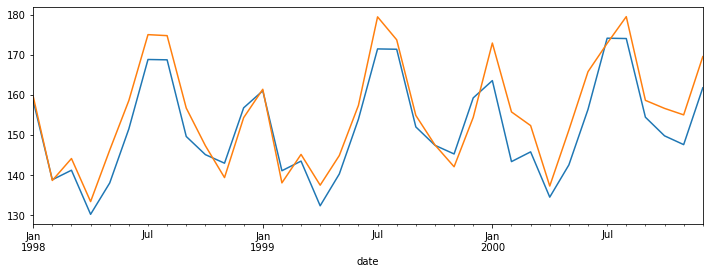

In [18]:
pd.Series(forecast, index=emissions_test.index).plot()
emissions_test.plot()
print(mae)

### Q6: Forecast the test set using multiple one-step forecasts

### Q6.1: Get the multiple one-step forecasts

In [19]:
# Don't forget to fit your sarimax model again
# You will need to make a for loop that updates the model

# sarimax_forecast_one_step_refit = []
# sarimax.fit(emissions_train_log)  
# emissions_test_logged = 
# Update loop

emissions_test_logged = np.log(emissions_test)

sarimax_forecast_one_step_refit = []
sarimax.fit(emissions_train_log)
for i in np.arange(0,36):
    next_step_forecast = sarimax.predict(1)[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax = sarimax.update(emissions_test_logged[i:i+1])



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-720.204, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-459.990, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-737.840, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-594.557, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-461.884, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-460.564, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-782.066, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-588.196, Time=0.16 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-787.849, Time=0.43 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-753.811, Time=0.40 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-732.110, Time=0.39 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-800.833, Time=0.40 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-793.954, Time=0.16 sec
 ARIMA(0,1,0)(2,0,0)[12]

In [20]:
expected_hash = '800db53174f6574102ffba037098e465c5756a6da7b4acd92271ae54bbd9eac1'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit)).encode()).hexdigest() == expected_hash

### Q6.2: Calculate the corresponding MAE

In [21]:
# Don't forget that you used the logged dataset when training the model.

# sarimax_forecast_one_step_refit_exp =
# mae =

sarimax_forecast_one_step_refit_exp = np.exp(sarimax_forecast_one_step_refit)
mae=mean_absolute_error(np.exp(sarimax_forecast_one_step_refit),np.exp(emissions_test_logged))

3.4482743093048893


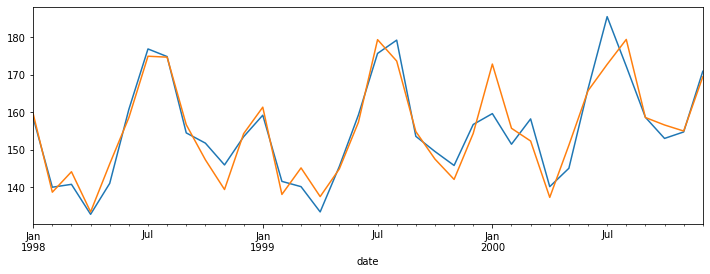

In [22]:
pd.Series(sarimax_forecast_one_step_refit_exp, index=emissions_test.index).plot()
emissions_test.plot()
print(mae)

In [23]:
expected_hash = 'a55edf466cf37e4a1d2bd6c7091627e358645538727d9876ebb7d3dd75cd772b'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit_exp,1)).encode()).hexdigest() == expected_hash

expected_hash = '72d73db944cf6d9a5f11d6c073c1dce0bde28a4d2341caf4ae976e858c62cabc'
assert hashlib.sha256(str(np.round(mae,1)).encode()).hexdigest() == expected_hash

### Q7: Forecast the test set using multiple one-step forecasts updated on each step with exog input.

Let's test the performance of our model using an exogenous input: the coal consumption. Note that this dataset contains the coal consumption forecast made on the previous month. This means that we can use this exogenous data for doing one-step forecasts. 

In [24]:
exog = load_coal_data()
exog_train = exog[:'1998']
exog_test = exog['1998':]

Let's look at the data to get an idea of what we can expect:

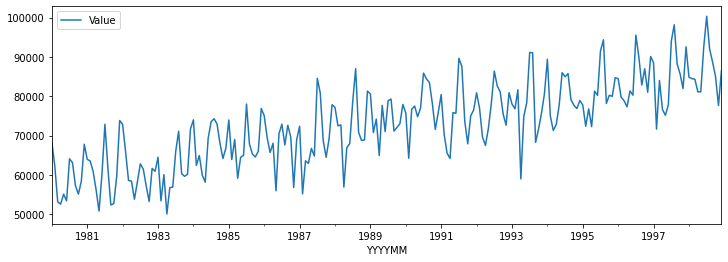

In [25]:
exog_train.plot();

### Q7.1: Get the multiple one-step forecasts with exog input

In [26]:
# Don't forget to fit your sarimax model again
# You will need to make a for loop that updates the model
# Note that this case is slightly different from the learning notebooks, where we used the exogenous data to do a
# multistep forecast. Here we need to use the exogenous data in the context of multiple one-step forecasts, this 
# means we need to have an update loop where we also include the new values of the exogenous data.

#sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=12, method='nm', maxiter=20)

sarimax_forecast_one_step_refit = []
sarimax.fit(emissions_train_log,exogenous=exog_train)

for i in np.arange(0,36):
    next_step_forecast = sarimax.predict(1,exogenous=exog_test[i:i+1])[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax = sarimax.update(emissions_test_logged[i:i+1],exogenous=exog_test[i:i+1])


In [37]:
expected_hash = '1a878151603301bf24597e803cb171b67c4eaad9da6ce7e7b9cb5b0541c4f89c'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit,1)).encode()).hexdigest() == expected_hash

### Q7.2: Calculate the corresponding MAE

In [42]:
# Don't forget that you used the logged dataset when training the model.

# sarimax_forecast_one_step_refit_exp = 
# mae = 
sarimax_forecast_one_step_refit_exp = np.exp(sarimax_forecast_one_step_refit)
mae=mean_absolute_error(sarimax_forecast_one_step_refit_exp,emissions_test)

4.82988795707557e+76


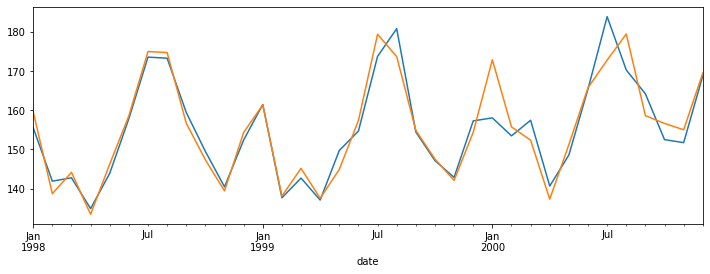

In [33]:
pd.Series(sarimax_forecast_one_step_refit_exp, index=emissions_test.index).plot()
emissions_test.plot()
print(mae)

In [43]:
expected_hash = '60d899f5a8b94c03219a705ed311542df3d66bed3599494d81db4b34ec5678fe'
assert hashlib.sha256(str(np.round(sarimax_forecast_one_step_refit_exp,1)).encode()).hexdigest() == expected_hash

expected_hash = '3135d2d71bff77be4838a7102bbac5b87af7fd0b9aef3d416f963a5afbb19061'
assert hashlib.sha256(str(np.round(mae,1)).encode()).hexdigest() == expected_hash